## Exercise 2.5 - Non-Stationary Problem
 
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for
non-stationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start
out equal and then take independent random walks (say by adding a normally distributed increment with
mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2
for an action-value method using sample averages, incrementally computed, and another action-value
method using a constant step-size parameter, $\alpha$=0.1. Use $\epsilon$=0.1 and longer runs, say of
10,000 steps.

In [1]:
!pip3 -q install numpy gym matplotlib ray

In [2]:
import ray
import gym
import gym.spaces
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bandit import run_episode
from gamblers import Gambler, AveragingGambler, EpsilonGreedyGambler

### Bandit Testbed (Stationary and Non-Stationary)

In [3]:
n = 10

class RandomGambler(Gambler):
    def arm(self):
        return self.np_random.choice(n)

random_gambler = RandomGambler()

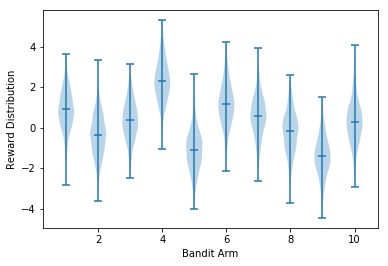

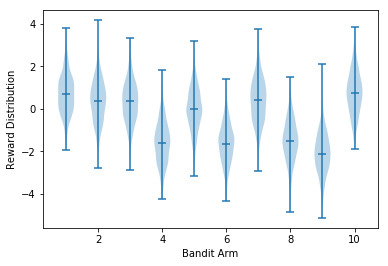

In [4]:
stationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True)
stationary.reset()

stationary.render()
run_episode(stationary, random_gambler)   
stationary.render()

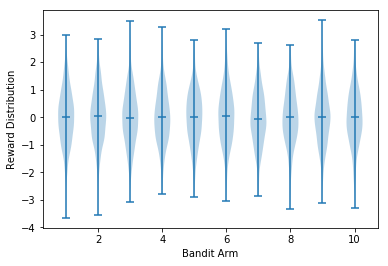

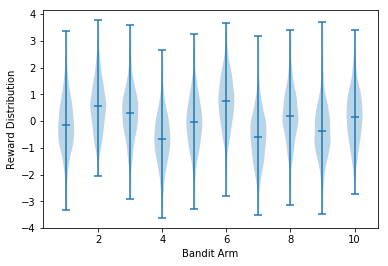

In [5]:
nonstationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False)
nonstationary.reset()

nonstationary.render()
run_episode(nonstationary, random_gambler)   
nonstationary.render()

#### Random Seed Repeatability

In [6]:
rewards0, corrects0, _ = run_episode(stationary, random_gambler, 7)
rewards1, corrects1, _ = run_episode(stationary, random_gambler, 7)

assert np.all(rewards0 == rewards1)
assert np.all(corrects0 == corrects1)

In [7]:
rewards0, corrects0, _ = run_episode(nonstationary, random_gambler, 7)
rewards1, corrects1, _ = run_episode(nonstationary, random_gambler, 7)

assert np.all(rewards0 == rewards1)
assert np.all(corrects0 == corrects1)

### Reproduction of Figure 2.2

In [8]:
ray.init(object_store_memory=1_000_000_000)


@ray.remote
def ray_episode(bandit, gambler, seed):
    rewards, corrects, steps = run_episode(bandit, gambler, seed)
    return rewards, corrects


def run_experiments(bandit, gamblers, num_episodes):
    bandit_id = ray.put(bandit)
    
    experiments = {}
    for label, gambler in gamblers.items():

        gambler_id = ray.put(gambler)
        seed = np.random.randint(2 ** 32 - 1 - num_episodes)
        episodes = [ray_episode.remote(bandit_id, gambler_id, seed + i) for i in range(num_episodes)]

        rewards, corrects = 0, 0
        while episodes:
            finished, episodes = ray.wait(episodes)
            eprews, epcors = ray.get(finished[0])
            rewards += (eprews - rewards) / (num_episodes - len(episodes))
            corrects += epcors

        experiments[label] = (rewards, corrects / num_episodes)

    return experiments

2019-09-11 20:50:55,962	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-09-11_20-50-55_961333_45916/logs.
2019-09-11 20:50:56,072	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:23456 to respond...
2019-09-11 20:50:56,195	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:20567 to respond...
2019-09-11 20:50:56,199	INFO services.py:809 -- Starting Redis shard with 3.44 GB max memory.
2019-09-11 20:50:56,214	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-09-11_20-50-55_961333_45916/logs.
2019-09-11 20:50:56,217	INFO services.py:1475 -- Starting the Plasma object store with 1.0 GB memory using /tmp.


In [9]:
matplotlib.rcParams['figure.figsize'] = [10, 5]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['g', 'b', 'r'])

def plot_experiments(results):
    fig_rewards = plt.figure()
    fig_corrects = plt.figure()


    for label, (rewards, corrects) in results.items():
        fig_rewards.gca().plot(rewards, label=label)
        fig_corrects.gca().plot(corrects, label=label)

    fig_rewards.gca().set_ylabel("Average reward")
    fig_rewards.gca().set_xlabel("Steps")
    fig_rewards.legend()
    
    fig_corrects.gca().set_ylabel("Optimal action")
    fig_corrects.gca().set_xlabel("Steps")
    fig_corrects.legend()

2019-09-11 20:50:57,657	WARNING worker.py:352 -- WARNING: Falling back to serializing objects of type <class 'numpy.dtype'> by using pickle. This may be inefficient.
2019-09-11 20:50:57,760	WARNING worker.py:352 -- WARNING: Falling back to serializing objects of type <class 'mtrand.RandomState'> by using pickle. This may be inefficient.


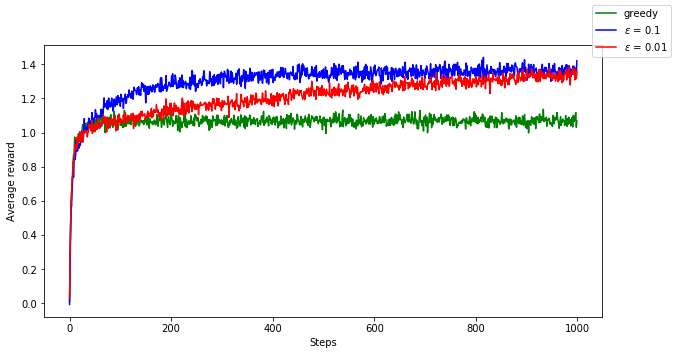

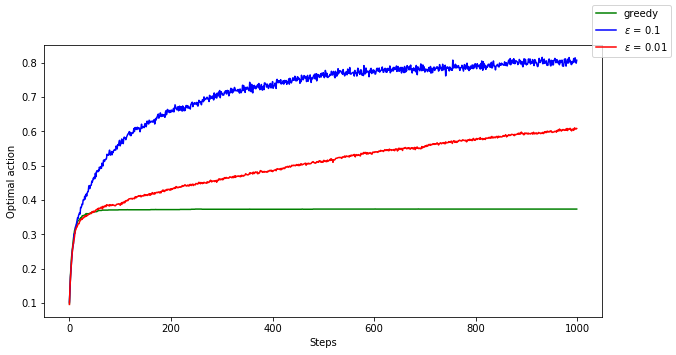

In [10]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True) 

gamblers = {
    r"greedy": AveragingGambler(n, epsilon=0),
    r"$\epsilon$ = 0.1": AveragingGambler(n, epsilon=0.1),
    r"$\epsilon$ = 0.01": AveragingGambler(n, epsilon=0.01)
}

experiments = run_experiments(bandit, gamblers, num_episodes=2_000)
plot_experiments(experiments)

### Sample Averaged and Fixed Step Gambler in a Non-Stationary Problem

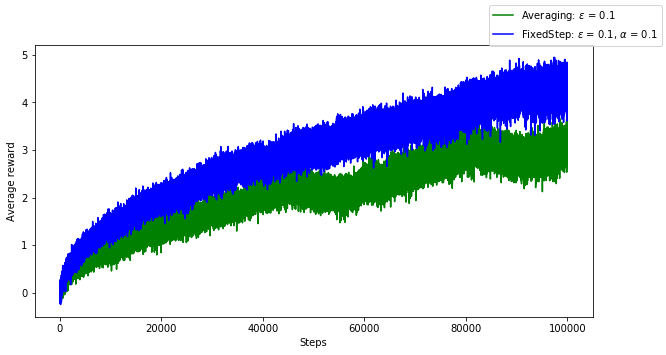

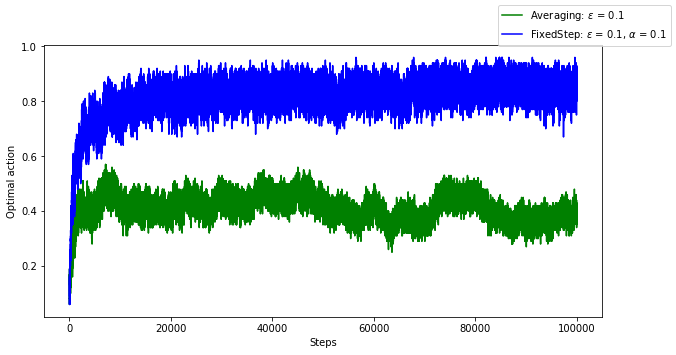

In [11]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False) 
bandit._max_episode_steps = 100_000

gamblers = {
    r"Averaging: $\epsilon$ = 0.1": AveragingGambler(n, epsilon=0.1),
    r"FixedStep: $\epsilon$ = 0.1, $\alpha$ = 0.1": EpsilonGreedyGambler(n, epsilon=0.1, alpha=0.1),
}

experiments = run_experiments(bandit, gamblers, num_episodes=100)
plot_experiments(experiments)